In [8]:
from influxdb import InfluxDBClient
import pandas as pd

client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values , columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 356 days of power generation data
generation = client.query("SELECT mean(Total) as TotalMean FROM Generation where time > now()-365d GROUP BY time(3h)")

# Get the last 365 days of weather forecasts with the shortest lead time
wind = client.query("SELECT * FROM MetForecasts where time > now()-365d and time <= now() and Lead_hours = '1'")

gen_df = get_df(generation)
wind_df = get_df(wind)

In [12]:
wind_df

,Direction,Lead_hours,Source_time,Speed
time,,,,
2020-10-10 21:00:00+00:00,NNW,1,1602352800,12.07008
2020-10-11 00:00:00+00:00,NNW,1,1602363600,12.96416
2020-10-11 03:00:00+00:00,N,1,1602374400,9.83488
2020-10-11 06:00:00+00:00,N,1,1602385200,9.83488
2020-10-11 09:00:00+00:00,N,1,1602396000,8.94080
...,...,...,...,...
2021-10-10 03:00:00+00:00,WSW,1,1633824000,9.83488
2021-10-10 06:00:00+00:00,WSW,1,1633834800,12.07008
2021-10-10 09:00:00+00:00,WSW,1,1633845600,12.07008


In [13]:
gen_df

,TotalMean
time,
2020-10-10 15:00:00+00:00,31.207407
2020-10-10 18:00:00+00:00,30.323779
2020-10-10 21:00:00+00:00,28.577252
2020-10-11 00:00:00+00:00,29.207123
2020-10-11 03:00:00+00:00,26.183600
...,...
2021-10-10 03:00:00+00:00,22.510567
2021-10-10 06:00:00+00:00,26.345422
2021-10-10 09:00:00+00:00,31.611767


In [10]:
#Join the datasets
combined = gen_df.join(wind_df)
combined = combined[combined['TotalMean'].notnull()]
combined

,TotalMean,Direction,Lead_hours,Source_time,Speed
time,,,,,
2020-12-19 12:00:00+00:00,26.999817,NaN,NaN,NaN,NaN
2020-12-19 15:00:00+00:00,27.579222,S,1,1.608383e+09,8.04672
2020-12-19 18:00:00+00:00,35.095871,S,1,1.608394e+09,8.94080
2020-12-19 21:00:00+00:00,34.858549,S,1,1.608404e+09,13.85824
2020-12-20 00:00:00+00:00,34.860129,S,1,1.608415e+09,11.17600
...,...,...,...,...,...
2021-12-19 00:00:00+00:00,5.135322,NW,1,1.639865e+09,4.91744
2021-12-19 03:00:00+00:00,6.842750,NW,1,1.639876e+09,4.91744
2021-12-19 06:00:00+00:00,4.200533,NNW,1,1.639886e+09,4.91744


In [15]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2903 entries, 2020-10-10 15:00:00+00:00 to 2021-10-10 15:00:00+00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TotalMean    2903 non-null   float64
 1   Direction    2776 non-null   object 
 2   Lead_hours   2776 non-null   object 
 3   Source_time  2776 non-null   float64
 4   Speed        2776 non-null   float64
dtypes: float64(3), object(2)
memory usage: 136.1+ KB


(0.0, 43.0)

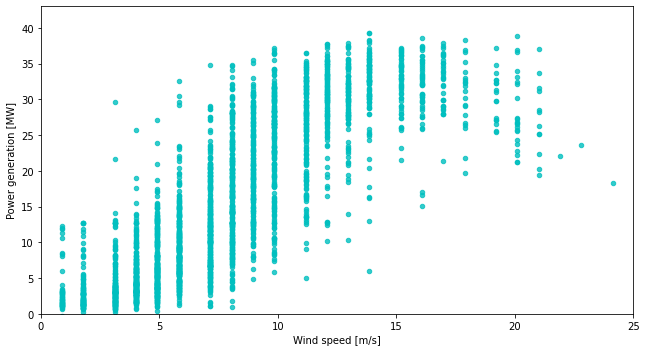

In [16]:
#Wind speed and power generation
import matplotlib.pyplot as plt
combined.plot.scatter("Speed", "TotalMean", alpha=0.8, color="c")
fig = plt.gcf()
fig.set_size_inches(9,5)
fig.tight_layout()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power generation [MW]")
plt.xlim(0,25)
plt.ylim(0,43)

In [17]:
## Preprocess the data
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# Custom transformer
class HourAdder(BaseEstimator,TransformerMixin):
    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.copy(deep=True)
        X.loc[:, "hour"] = X.index.hour
        return X

class MonthAdder(BaseEstimator,TransformerMixin):
    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.copy(deep=True)
        X.loc[:, "Month"] = X.index.month
        return X

# Altering the wind direction to be a usable feature 
direction_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

#Preprocess the data from Speed and Direction
preprocessor = ColumnTransformer(
    transformers=[
        ("imputer", SimpleImputer(strategy="mean"), ["Speed"]),
        ('direction', direction_transformer, ['Direction']),
    ],
    remainder = "passthrough")

# Add to the pipeline. Why HourAdder and MonthAdder was removed is explained in the report.
pipeline = Pipeline(steps=[
                        #("HourAdder", HourAdder()),
                        #("MonthAdder", MonthAdder()),
                        ('preprocessor', preprocessor),
                        ("poly",PolynomialFeatures(degree=3)),
                        ("Scaler", StandardScaler(with_mean=False)),
                        ('classifier', LinearRegression())])

In [18]:
#Visually display the Pipeline
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer', SimpleImputer(),
                                                  ['Speed']),
                                                 ('direction',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Direction'])])),
                ('poly', PolynomialFeatures(degree=3)),
                ('Scaler', StandardScaler(with_mean=False)),
                ('classifier', LinearRegression())])

In [19]:
# Fit the pipeline on the real values of X and y
from sklearn.metrics import mean_absolute_error
X = combined[["Speed", "Direction"]]
y = combined["TotalMean"]
model = pipeline.fit(X,y)
Y_hat = pipeline.predict(X)
mae = mean_absolute_error(y, Y_hat)
print(mae)

4.297380336994228


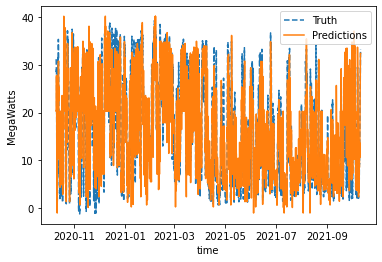

In [20]:
#Displaying how the model works on the data from the database
import matplotlib.pyplot as plt
plt.plot(combined.index, y, "--", label = "Truth")
plt.plot(combined.index, Y_hat, label = "Predictions")
plt.xlabel("time")
plt.ylabel("MegaWatts")
plt.legend()
plt.show()

In [21]:
#Fit the pipeline on the training and test sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
model = pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_hat)

#MAE and scores of the trainign and test set
print("MAE:", mae)
print('Training set score: ' + str(model.score(X_train,y_train)))
print('Test set score: ' + str(model.score(X_test,y_test)))


MAE: 3.7854258295533976
Training set score: 0.7361884479839962
Test set score: 0.6370651271836633


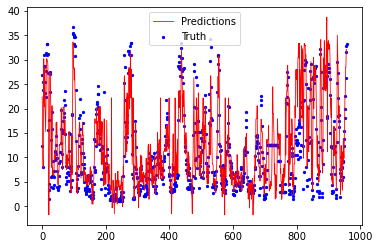

In [22]:
#Display the prediction and the real data
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="Truth")
plt.plot(x_ax, y_hat, lw=0.8, color="red", label="Predictions")
plt.legend()
plt.show() 

In [23]:
#Make a forecast
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()"
    ) # Query written in InfluxQL
forecast_df = get_df(forecasts)
newest_source_time = forecast_df["Source_time"].max()

newest_forecasts = forecast_df.loc[forecast_df["Source_time"] == newest_source_time].copy()
print(newest_forecasts)

                          Direction Lead_hours  Source_time     Speed
time                                                                 
2021-10-10 18:00:00+00:00       WNW          3   1633870800  12.07008
2021-10-10 21:00:00+00:00        NW          6   1633870800  12.96416
2021-10-11 00:00:00+00:00        NW          9   1633870800   9.83488
2021-10-11 03:00:00+00:00        NW         12   1633870800   9.83488
2021-10-11 06:00:00+00:00       WNW         15   1633870800   8.94080
2021-10-11 09:00:00+00:00       WNW         18   1633870800   9.83488
2021-10-11 12:00:00+00:00        NW         21   1633870800  11.17600
2021-10-11 15:00:00+00:00       NNW         24   1633870800   9.83488
2021-10-11 18:00:00+00:00       NNW         27   1633870800   8.94080
2021-10-11 21:00:00+00:00       NNW         30   1633870800   7.15264
2021-10-12 00:00:00+00:00       NNW         33   1633870800   5.81152
2021-10-12 03:00:00+00:00       NNW         36   1633870800   4.91744
2021-10-12 06:00:00+

In [24]:
#Make a prediction of the power generation based on the just created forecast
df = pd.DataFrame(data=newest_forecasts, columns=["Speed","Direction"])
print(pipeline.predict(df))

[28.78125 28.53125 20.21875 20.21875 20.34375 23.0625  24.03125 19.125
 16.59375 11.78125  8.6875   6.96875  4.375    4.375    3.78125  3.78125
  2.59375  4.65625  8.       9.84375 13.      19.96875 22.40625 25.96875
 28.      28.      28.40625 28.40625 28.      28.      25.96875 28.78125
 26.71875 26.71875]
